In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [20]:
path = 'lfw'

In [21]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [22]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


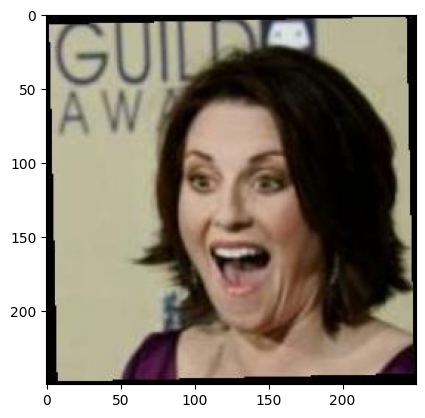

In [23]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Dimensions of the sample image: torch.Size([3, 250, 250])


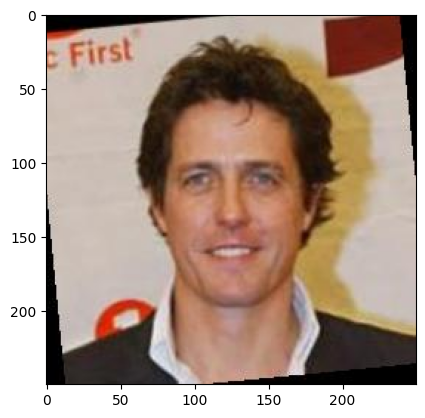

In [24]:
images, _ = next(iter(dataloader))
sample_image = images[0]

# Dimensions of the image
print(f"Dimensions of the sample image: {sample_image.shape}")

sample_image_display = sample_image.permute(1, 2, 0).numpy()  # Change (C, H, W) to (H, W, C)
plt.imshow(sample_image_display)
# plt.axis('off')  # Turn off axis numbers
plt.show()

### 3 (Color Channels): 
The first number, 3, represents the number of color channels in the image. For standard RGB images, there are three channels corresponding to the colors Red, Green, and Blue.

### 250 (Height): 
The second number is the height of the image in pixels. In this case, the height of the image is 250 pixels.

### 250 (Width): 
The third number is the width of the image in pixels, which is also 250 pixels in this example.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [25]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.init_encoder_layers() # Initializing the encoder layers
        self.init_decoder_layers() # Initializing the decoder layers

    def init_encoder_layers(self):
        # Defining encoder layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # First convolutional layer: takes 3 input channels, outputs 32, with a kernel size of 4, stride of 2, and padding of 1
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)   # Second convolutional layer: takes 32 input channels, outputs 64, with the same kernel size, stride, and padding
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Third convolutional layer: takes 64 input channels, outputs 128, with the same kernel size, stride, and padding

    def init_decoder_layers(self):
        # Defining decoder layers
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # First deconvolutional layer: takes 128 input channels, outputs 64, with a kernel size of 4, stride of 2, and padding of 1
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Second deconvolutional layer: takes 64 input channels, outputs 32, with the same kernel size, stride, and padding
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0)   # Third deconvolutional layer: takes 32 input channels, outputs 3, with a kernel size of 4, stride of 2, and no padding


    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))  # Applying first convolutional layer followed by a ReLU activation function
        x = F.relu(self.enc_conv2(x))  # Applying second convolutional layer followed by a ReLU activation function
        x = F.relu(self.enc_conv3(x))  # Applying third convolutional layer followed by a ReLU activation function
        return x 

    def decoder(self, x):
        x = F.relu(self.dec_conv1(x))  # Applying first deconvolutional layer followed by a ReLU activation function
        x = F.relu(self.dec_conv2(x))  # Applying second deconvolutional layer followed by a ReLU activation function
        x = torch.sigmoid(self.dec_conv3(x))  # Applying third deconvolutional layer followed by a sigmoid activation function
        return x 
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x # final output of autoencoder

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [26]:
# Create instance of the AutoEncoder class
autoencoder = AE()

image_given = sample_image.unsqueeze(0)  

# image using autoencoder
encoded = autoencoder.encoder(image_given)
decoded = autoencoder.decoder(encoded)

# Shapes of encoded and decoded outputs
print("Encoded shape:", encoded.shape)
print("Decoded shape:", decoded.shape)

Encoded shape: torch.Size([1, 128, 31, 31])
Decoded shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optim for training

Autoencode model particularly for tasks involving image data, a common and effective choice of loss function is the Mean Squared Error (MSE) loss. This loss function calculates average of the squares of the differences between the actual and the predicted values, making it better choice for tasks where precision in reconstructing the original image is crucial.

While choosing optimizer, a good choice is the Adam optimizer. Adam stands out for its adaptive learning rate capabilities, making it efficient for a wide range of applications. It combines advantages of two other popular optimizers: AdaGrad and RMSProp, and adjusting the learning rate for each parameter based on the first (mean) and second (variance) moments of the gradients.

In [27]:
total_params = 0
for name, parameter in autoencoder.named_parameters():
    if parameter.requires_grad:
        param = parameter.numel()
        total_params += param
        print(f"{name} has {param} parameters")
print(f"Total number of trainable parameters: {total_params}")

enc_conv1.weight has 1536 parameters
enc_conv1.bias has 32 parameters
enc_conv2.weight has 32768 parameters
enc_conv2.bias has 64 parameters
enc_conv3.weight has 131072 parameters
enc_conv3.bias has 128 parameters
dec_conv1.weight has 131072 parameters
dec_conv1.bias has 64 parameters
dec_conv2.weight has 32768 parameters
dec_conv2.bias has 32 parameters
dec_conv3.weight has 1536 parameters
dec_conv3.bias has 3 parameters
Total number of trainable parameters: 331075


In [28]:
# 3. optimizer Creation
optim = torch.optim.Adam(autoencoder.parameters(), lr=0.001)  # You can adjust the learning rate as needed

In [29]:
# 2. Loss function selection
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

If the loss value of autoencoder is not decreasing during training, We can consider the following troubleshooting steps:

1. **Learning Rate Adjustment**: A high learning rate can cause overshooting, while a low rate can slow down the training. We will Try varying the learning rate to find a more optimal setting.

2. **Model Architecture Review**: We will Ensure whether the complexity of autoencoder matches the complexity of your dataset and adjust the number of layers or adding more activatioon functions as needed.

3. **Data Preprocessing**: Checking for proper data normalization and for missing or corrupt values.

4. **Change Batch Size**: Experimenting with different batch sizes, as very large or small sizes can impact the training stability.

5. **Use Regularization**: We can Implement techniques like dropout or L1/L2 regularization to prevent overfitting.

6. **Switch optimizers**: Trying out different optimizers like Adam or RMSprop, which may be more effective.

7. **Implement Early Stopping**: If loss decreases then increases, it indicates overfitting. Use early stopping to halt training at the optimal point.


Addressing these areas can help improve the model's learning process and reduce the loss over time we can have many more troubleshooting techniques.

In [30]:
# MPS (Apple Silicon GPU) is available and used it;
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Moving the model to the mps device
autoencoder = autoencoder.to(device)

# Training loop
epoch_count = 20
for epoch in range(epoch_count):
    total_loss = 0
    for data, _ in dataloader:
        # Move data to the device as the model
        data = data.to(device)

        # Forward optimizations
        output = autoencoder(data)
        loss = loss_function(output, data)
        
        # Backward optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epoch_count}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.0085
Epoch [2/20], Loss: 0.0017
Epoch [3/20], Loss: 0.0011
Epoch [4/20], Loss: 0.0009
Epoch [5/20], Loss: 0.0008
Epoch [6/20], Loss: 0.0006
Epoch [7/20], Loss: 0.0006
Epoch [8/20], Loss: 0.0005
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0005
Epoch [11/20], Loss: 0.0005
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

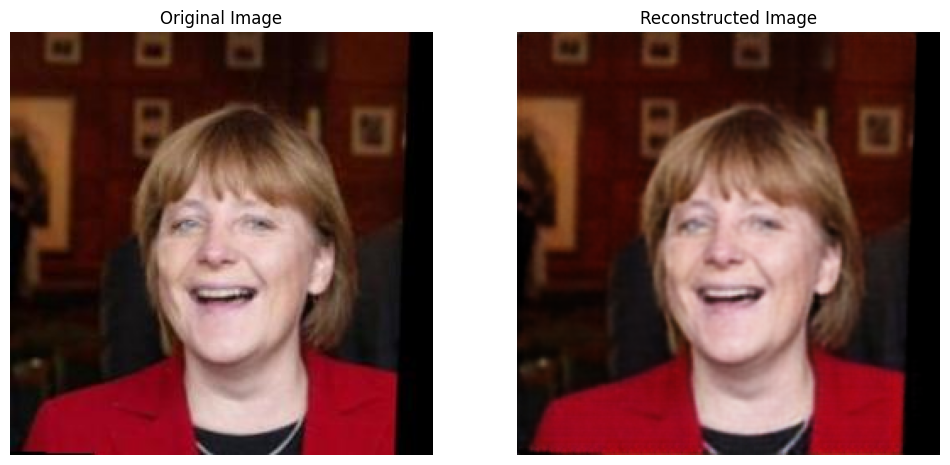

In [33]:
# choosing a random image from given lfw dataset
image_selection_data = iter(dataloader)
images, _ = next(image_selection_data)
original_image = images[0].to(device)

# Passing the image via the autoencoder
with torch.no_grad():
    autoencoder.eval()
    reconstructed_image = autoencoder(original_image.unsqueeze(0))

# Converting images for display
original_image_display = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_display = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Displaying images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_display)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Adding noise to the decoding process of an image typically leads to a decrease in image quality. This manifests as graininess, blurriness, or distortions in the image, which can obscure details and reduce the overall sharpness and clarity. In digital image processing, noise can interfere with the accurate representation of the image's original content, making it harder to perceive or analyze the true features of the image.

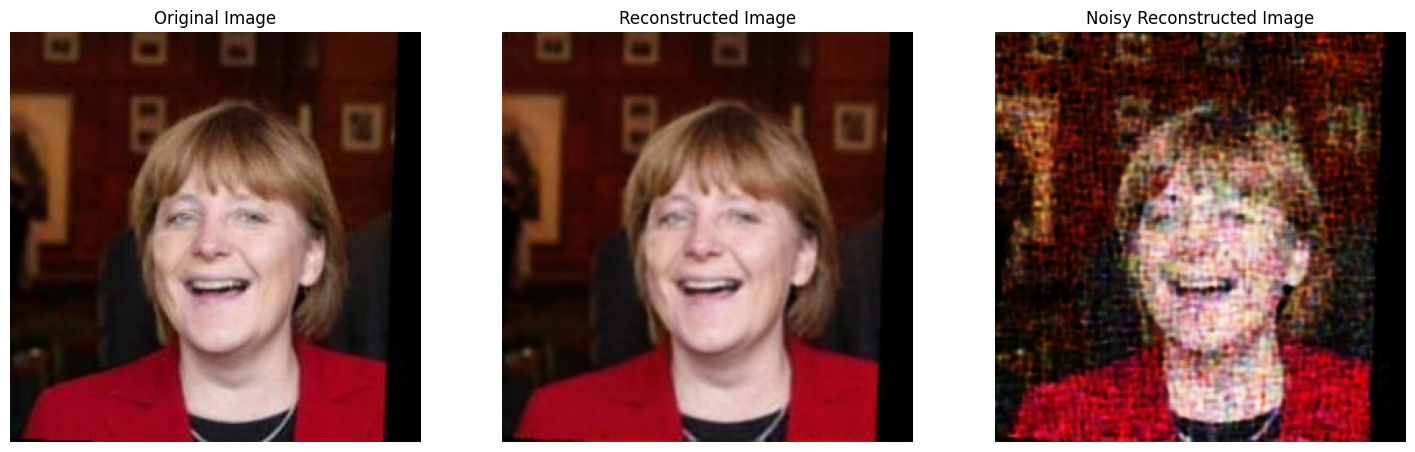

In [35]:
# Adding noise to the latent representation
noise_level = 0.5
with torch.no_grad():
    encoded = autoencoder.encoder(original_image.unsqueeze(0))
    noise = torch.randn_like(encoded) * noise_level  # Increased noise level
    noisy_encoded = encoded + noise
    noisy_reconstructed_with_more_noise = autoencoder.decoder(noisy_encoded)

noisy_reconstructed_display = noisy_reconstructed_with_more_noise.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Displaying the original, reconstructed, and noisy reconstructed images side by side
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image_display)
plt.title("Original Image")
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_display)
plt.title("Reconstructed Image")
plt.axis('off')

# Noisy Reconstructed Image
plt.subplot(1, 3, 3)
plt.imshow(noisy_reconstructed_display)
plt.title("Noisy Reconstructed Image")
plt.axis('off')

plt.show()
